## If in Colab

In [1]:
in_colab = False

In [2]:
if in_colab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

In [3]:
if in_colab:
    import sys
    data_dir = "/content/drive/MyDrive/data/"
    VOC2012_path = data_dir
    tracker_path = data_dir
    sys.path.append(tracker_path)
    ssd_weights_path = data_dir + "ssd_weights_epoch_0380.h5"
else:
    data_dir = "../data/"
    VOC2012_path = data_dir + "VOCdevkit/"
    tracker_path = "../Tracking_SSD_ReID/"
    ssd_weights_path = data_dir + "ssd_weights_epoch_0380.h5"

## Import model

In [4]:
import tensorflow as tf

In [5]:
from models.FCN8 import FCN8
model = FCN8(tracker_ssd_path = tracker_path, 
             ssd_weights_path = ssd_weights_path)

## Prepare VOC2012 segmentation data

  1%|▌                                                                              | 20/2913 [00:00<00:15, 190.89it/s]


Loading images...


  2%|█▍                                                                             | 55/2913 [00:00<00:05, 514.35it/s]


Loading annotations...


100%|█████████████████████████████████████████████████████████████████████████████| 2913/2913 [00:03<00:00, 746.39it/s]



Convert to tensor...

Done
Images shape: (2913, 300, 300, 3), annotations shape: (2913, 300, 300, 1)


  0%|▎                                                                              | 12/2913 [00:00<00:26, 108.37it/s]

Reshape gt from (300, 300, 1) to (300, 300, n_classes)


100%|█████████████████████████████████████████████████████████████████████████████| 2913/2913 [00:23<00:00, 123.49it/s]


Images shape: (2913, 300, 300, 3), annotations shape: (2913, 300, 300, 21)
Examples:


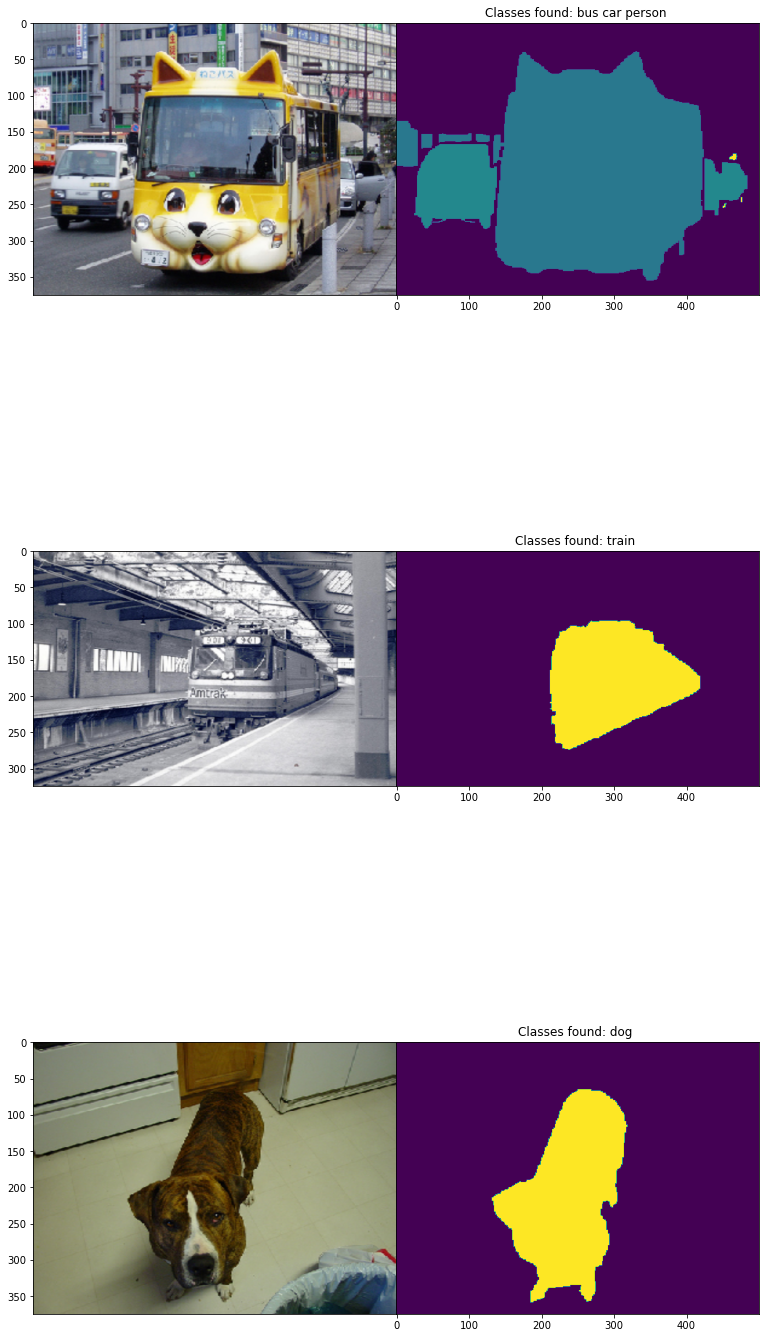

In [6]:
from data_management.VOC2012Manager import VOC2012Manager

manager = VOC2012Manager()
images, gt_annotations, filenames_png, original_shapes =\
    manager.load_and_prepare_data(VOC2012_path=VOC2012_path, width_height=(300, 300,), n_samples_to_show=5)

In [7]:
train_ratio = 0.7
batch_size = 32
train_dataset, val_dataset = manager.tensorf2TFData(images, gt_annotations, train_ratio, batch_size)

In [8]:
for train_img, train_annot in train_dataset:
    break
for val_img, val_annot in val_dataset:
    break

In [9]:
print(f"Train images shape: {train_img.shape}, train annotations shape: {train_annot.shape}")
print(f"Val images shape: {val_img.shape}, Val annotations shape: {val_annot.shape}")

Train images shape: (32, 300, 300, 3), train annotations shape: (32, 300, 300, 21)
Val images shape: (300, 300, 3), Val annotations shape: (300, 300, 21)


## Train model

In [10]:
sgd = tf.keras.optimizers.SGD(lr=1E-2, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
# number of training images
train_count = images.shape[0] * train_ratio

# number of validation images
validation_count = images.shape[0] * (1 - train_ratio)

epochs = 1

steps_per_epoch = train_count//batch_size
validation_steps = validation_count//batch_size

checkpoint_filepath = '../data/weights/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset, validation_steps=validation_steps,
                    epochs=epochs, callbacks=[model_checkpoint_callback])